# Salary Prediction ML Project

Complete machine learning model for salary prediction, including:
- Data loading and inspection
- Exploratory Data Analysis (EDA)
- Data preprocessing
- Model training (Linear Regression, Random Forest, Gradient Boosting, Voting Regressor)
- Model comparison and evaluation
- Feature importance analysis

## Import Required Libraries
Import all necessary libraries for data processing, visualization, and machine learning.

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration
DATA_PATH = 'data/salary_prediction_data.csv'
MODEL_SAVE_PATH = 'best_model.pkl'
PREPROCESSOR_SAVE_PATH = 'preprocessor.pkl'

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Helper Functions
Define utility functions for formatted output and section headers.

In [2]:
def print_section(title):
    """Print formatted section header"""
    print("\n" + "=" * 80)
    print(f" {title}")
    print("=" * 80)

## 1. Load and Inspect Data
Load the salary prediction dataset and perform initial inspection to understand its structure.

In [3]:
def load_and_inspect_data(file_path):
    """Load dataset and perform initial inspection"""
    print_section("1. LOADING AND INSPECTING DATA")
    
    print(f"\n📂 Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    
    print(f"✓ Data loaded successfully!")
    print(f"\n📊 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    
    print("\n📋 First 5 rows:")
    print(df.head())
    
    print("\n📋 Dataset Info:")
    print(df.info())
    
    print("\n📋 Column Names:")
    print(df.columns.tolist())
    
    return df

# Load the data
df = load_and_inspect_data(DATA_PATH)


 1. LOADING AND INSPECTING DATA

📂 Loading data from: data/salary_prediction_data.csv
✓ Data loaded successfully!

📊 Dataset Shape: 1000 rows × 7 columns

📋 First 5 rows:
     Education  Experience  Location Job_Title  Age  Gender         Salary
0  High School           8     Urban   Manager   63    Male   84620.053665
1          PhD          11  Suburban  Director   59    Male  142591.255894
2     Bachelor          28  Suburban   Manager   61  Female   97800.255404
3  High School          29     Rural  Director   45    Male   96834.671282
4          PhD          25     Urban   Analyst   26  Female  132157.786175

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Education   1000 non-null   object 
 1   Experience  1000 non-null   int64  
 2   Location    1000 non-null   object 
 3   Job_Title   1000 non-null   object 
 4   Age  

## 2. Exploratory Data Analysis (EDA)
Analyze the dataset to understand distributions, correlations, and missing values.

In [4]:
def perform_eda(df):
    """Perform exploratory data analysis"""
    print_section("2. EXPLORATORY DATA ANALYSIS (EDA)")
    
    # Basic statistics
    print("\n📈 Statistical Summary:")
    print(df.describe())
    
    # Missing values
    print("\n🔍 Missing Values Analysis:")
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Count': missing_values.values,
        'Missing Percentage': missing_percent.values
    })
    print(missing_df[missing_df['Missing Count'] > 0] if missing_df['Missing Count'].sum() > 0 
          else "✓ No missing values found!")
    
    # Data types
    print("\n📊 Data Types:")
    print(df.dtypes)
    
    # Categorical columns value counts
    print("\n📊 Categorical Features Distribution:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'Salary':
            print(f"\n{col}:")
            print(df[col].value_counts())
    
    # Numerical columns correlation
    print("\n📊 Numerical Features Correlation with Salary:")
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if 'Salary' in numerical_cols:
        correlations = df[numerical_cols].corr()['Salary'].sort_values(ascending=False)
        print(correlations)
    
    # Target variable statistics
    if 'Salary' in df.columns:
        print("\n💰 Target Variable (Salary) Statistics:")
        print(f"  Mean: ${df['Salary'].mean():,.2f}")
        print(f"  Median: ${df['Salary'].median():,.2f}")
        print(f"  Std Dev: ${df['Salary'].std():,.2f}")
        print(f"  Min: ${df['Salary'].min():,.2f}")
        print(f"  Max: ${df['Salary'].max():,.2f}")
    
    return df

# Perform EDA
df = perform_eda(df)


 2. EXPLORATORY DATA ANALYSIS (EDA)

📈 Statistical Summary:
        Experience          Age         Salary
count  1000.000000  1000.000000    1000.000000
mean     14.771000    42.377000  105558.404239
std       8.341111    13.609412   28256.972075
min       1.000000    20.000000   33510.510669
25%       7.000000    30.000000   85032.141517
50%      15.000000    43.000000  104314.518315
75%      22.000000    55.000000  126804.047524
max      29.000000    64.000000  193016.602150

🔍 Missing Values Analysis:
✓ No missing values found!

📊 Data Types:
Education      object
Experience      int64
Location       object
Job_Title      object
Age             int64
Gender         object
Salary        float64
dtype: object

📊 Categorical Features Distribution:

Education:
Education
High School    255
Bachelor       253
PhD            251
Master         241
Name: count, dtype: int64

Location:
Location
Suburban    345
Rural       345
Urban       310
Name: count, dtype: int64

Job_Title:
Job_Title


## 3. Data Preprocessing
Handle missing values, standardize column names, and create preprocessing pipelines for categorical and numerical features.

In [5]:
def preprocess_data(df):
    """Preprocess the data: handle missing values, encode categoricals, scale features"""
    print_section("3. DATA PREPROCESSING")
    
    # Standardize column names (handle case differences)
    df.columns = df.columns.str.strip()
    
    # Map column names to expected names
    column_mapping = {
        'Education': 'education_level',
        'Experience': 'years_experience',
        'Location': 'location',
        'Job_Title': 'job_title',
        'Age': 'age',
        'Gender': 'gender',
        'Salary': 'salary'
    }
    
    df = df.rename(columns=column_mapping)
    
    print("\n✓ Column names standardized")
    print(f"Columns: {df.columns.tolist()}")
    
    # Handle missing values
    print("\n🔧 Handling missing values...")
    initial_missing = df.isnull().sum().sum()
    
    # Fill numerical missing values with median
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
            print(f"  - Filled {col} with median")
    
    # Fill categorical missing values with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
            print(f"  - Filled {col} with mode")
    
    final_missing = df.isnull().sum().sum()
    print(f"✓ Missing values handled: {initial_missing} → {final_missing}")
    
    # Separate features and target
    if 'salary' not in df.columns:
        raise ValueError("Target column 'salary' not found in dataset!")
    
    X = df.drop('salary', axis=1)
    y = df['salary']
    
    print(f"\n✓ Features shape: {X.shape}")
    print(f"✓ Target shape: {y.shape}")
    
    # Identify categorical and numerical columns
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"\n📊 Feature Types:")
    print(f"  Categorical features ({len(categorical_features)}): {categorical_features}")
    print(f"  Numerical features ({len(numerical_features)}): {numerical_features}")
    
    # Create preprocessing pipelines
    print("\n🔧 Creating preprocessing pipeline...")
    
    # For categorical: OneHotEncoder
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    # For numerical: StandardScaler
    numerical_transformer = StandardScaler()
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    print("✓ Preprocessing pipeline created")
    
    return X, y, preprocessor, categorical_features, numerical_features

# Preprocess the data
X, y, preprocessor, categorical_features, numerical_features = preprocess_data(df)


 3. DATA PREPROCESSING

✓ Column names standardized
Columns: ['education_level', 'years_experience', 'location', 'job_title', 'age', 'gender', 'salary']

🔧 Handling missing values...
✓ Missing values handled: 0 → 0

✓ Features shape: (1000, 6)
✓ Target shape: (1000,)

📊 Feature Types:
  Categorical features (4): ['education_level', 'location', 'job_title', 'gender']
  Numerical features (2): ['years_experience', 'age']

🔧 Creating preprocessing pipeline...
✓ Preprocessing pipeline created


## 4. Split Data into Training and Test Sets
Split the data into training (80%) and test (20%) sets for model evaluation.

In [6]:
def split_data(X, y, test_size=0.2):
    """Split data into train and test sets"""
    print_section("4. SPLITTING DATA")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE
    )
    
    print(f"\n✓ Data split completed:")
    print(f"  Training set: {X_train.shape[0]} samples ({(1-test_size)*100:.0f}%)")
    print(f"  Test set: {X_test.shape[0]} samples ({test_size*100:.0f}%)")
    print(f"  Features: {X_train.shape[1]} columns")
    
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(X, y)


 4. SPLITTING DATA

✓ Data split completed:
  Training set: 800 samples (80%)
  Test set: 200 samples (20%)
  Features: 6 columns


## 5. Train Baseline Model (Linear Regression)
Train a baseline Linear Regression model to establish a performance benchmark.

In [7]:
def train_baseline_model(X_train, X_test, y_train, y_test, preprocessor):
    """Train baseline Linear Regression model"""
    print_section("5. TRAINING BASELINE MODEL (Linear Regression)")
    
    print("\n🤖 Training Linear Regression model...")
    
    # Create pipeline with preprocessing and model
    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    # Train model
    lr_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = lr_pipeline.predict(X_train)
    y_test_pred = lr_pipeline.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print("✓ Model trained successfully!")
    print(f"\n📊 Performance Metrics:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: ${test_rmse:,.2f}")
    print(f"  Test MAE: ${test_mae:,.2f}")
    
    return lr_pipeline, {
        'name': 'Linear Regression',
        'train_r2': train_r2,
        'test_r2': test_r2,
        'rmse': test_rmse,
        'mae': test_mae
    }

# Train baseline model
baseline_model, baseline_metrics = train_baseline_model(
    X_train, X_test, y_train, y_test, preprocessor
)


 5. TRAINING BASELINE MODEL (Linear Regression)

🤖 Training Linear Regression model...
✓ Model trained successfully!

📊 Performance Metrics:
  Train R²: 0.8790
  Test R²: 0.8702
  Test RMSE: $10,295.45
  Test MAE: $8,157.90
✓ Model trained successfully!

📊 Performance Metrics:
  Train R²: 0.8790
  Test R²: 0.8702
  Test RMSE: $10,295.45
  Test MAE: $8,157.90


## 6. Train Advanced Models
Train more sophisticated models:
- **Random Forest Regressor**: Ensemble of decision trees
- **Gradient Boosting Regressor**: Sequential ensemble method
- **Voting Regressor**: Ensemble of all models combined

In [8]:
def train_advanced_models(X_train, X_test, y_train, y_test, preprocessor):
    """Train advanced models: Random Forest, Gradient Boosting, and Voting Regressor"""
    print_section("6. TRAINING ADVANCED MODELS")
    
    results = []
    models = {}
    
    # Random Forest
    print("\n🌲 Training Random Forest Regressor...")
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])
    rf_pipeline.fit(X_train, y_train)
    
    y_train_pred_rf = rf_pipeline.predict(X_train)
    y_test_pred_rf = rf_pipeline.predict(X_test)
    
    rf_metrics = {
        'name': 'Random Forest',
        'train_r2': r2_score(y_train, y_train_pred_rf),
        'test_r2': r2_score(y_test, y_test_pred_rf),
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
        'mae': mean_absolute_error(y_test, y_test_pred_rf)
    }
    results.append(rf_metrics)
    models['Random Forest'] = rf_pipeline
    print(f"✓ Random Forest - Test R²: {rf_metrics['test_r2']:.4f}, RMSE: ${rf_metrics['rmse']:,.2f}")
    
    # Gradient Boosting
    print("\n🚀 Training Gradient Boosting Regressor...")
    gb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_STATE
        ))
    ])
    gb_pipeline.fit(X_train, y_train)
    
    y_train_pred_gb = gb_pipeline.predict(X_train)
    y_test_pred_gb = gb_pipeline.predict(X_test)
    
    gb_metrics = {
        'name': 'Gradient Boosting',
        'train_r2': r2_score(y_train, y_train_pred_gb),
        'test_r2': r2_score(y_test, y_test_pred_gb),
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_gb)),
        'mae': mean_absolute_error(y_test, y_test_pred_gb)
    }
    results.append(gb_metrics)
    models['Gradient Boosting'] = gb_pipeline
    print(f"✓ Gradient Boosting - Test R²: {gb_metrics['test_r2']:.4f}, RMSE: ${gb_metrics['rmse']:,.2f}")
    
    # Voting Regressor (ensemble of all models)
    print("\n🎯 Training Voting Regressor (Ensemble)...")
    
    # Create base estimators without preprocessing (we'll add preprocessing separately)
    lr_base = LinearRegression()
    rf_base = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    gb_base = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE
    )
    
    voting_reg = VotingRegressor(
        estimators=[
            ('lr', lr_base),
            ('rf', rf_base),
            ('gb', gb_base)
        ]
    )
    
    voting_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', voting_reg)
    ])
    
    voting_pipeline.fit(X_train, y_train)
    
    y_train_pred_voting = voting_pipeline.predict(X_train)
    y_test_pred_voting = voting_pipeline.predict(X_test)
    
    voting_metrics = {
        'name': 'Voting Regressor',
        'train_r2': r2_score(y_train, y_train_pred_voting),
        'test_r2': r2_score(y_test, y_test_pred_voting),
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_voting)),
        'mae': mean_absolute_error(y_test, y_test_pred_voting)
    }
    results.append(voting_metrics)
    models['Voting Regressor'] = voting_pipeline
    print(f"✓ Voting Regressor - Test R²: {voting_metrics['test_r2']:.4f}, RMSE: ${voting_metrics['rmse']:,.2f}")
    
    return results, models

# Train advanced models
advanced_metrics, advanced_models = train_advanced_models(
    X_train, X_test, y_train, y_test, preprocessor
)


 6. TRAINING ADVANCED MODELS

🌲 Training Random Forest Regressor...
✓ Random Forest - Test R²: 0.8465, RMSE: $11,196.22

🚀 Training Gradient Boosting Regressor...
✓ Random Forest - Test R²: 0.8465, RMSE: $11,196.22

🚀 Training Gradient Boosting Regressor...
✓ Gradient Boosting - Test R²: 0.8369, RMSE: $11,541.57

🎯 Training Voting Regressor (Ensemble)...
✓ Gradient Boosting - Test R²: 0.8369, RMSE: $11,541.57

🎯 Training Voting Regressor (Ensemble)...
✓ Voting Regressor - Test R²: 0.8602, RMSE: $10,683.33
✓ Voting Regressor - Test R²: 0.8602, RMSE: $10,683.33


## 7. Compare Model Performance
Compare all trained models and identify the best performing model based on Test R² score.

In [9]:
def compare_models(baseline_metrics, advanced_metrics):
    """Compare all models and display results in tabular format"""
    print_section("7. MODEL PERFORMANCE COMPARISON")
    
    # Combine all metrics
    all_metrics = [baseline_metrics] + advanced_metrics
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(all_metrics)
    comparison_df = comparison_df[['name', 'train_r2', 'test_r2', 'rmse', 'mae']]
    comparison_df.columns = ['Model', 'Train R²', 'Test R²', 'RMSE ($)', 'MAE ($)']
    
    # Sort by Test R² (descending)
    comparison_df = comparison_df.sort_values('Test R²', ascending=False)
    
    print("\n📊 Performance Comparison Table:")
    print("=" * 90)
    print(f"{'Model':<25} {'Train R²':<12} {'Test R²':<12} {'RMSE ($)':<15} {'MAE ($)':<15}")
    print("=" * 90)
    
    for _, row in comparison_df.iterrows():
        print(f"{row['Model']:<25} {row['Train R²']:<12.4f} {row['Test R²']:<12.4f} "
              f"{row['RMSE ($)']:<15,.2f} {row['MAE ($)']:<15,.2f}")
    
    print("=" * 90)
    
    # Find best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_r2 = comparison_df.iloc[0]['Test R²']
    
    print(f"\n🏆 Best Model: {best_model_name} (Test R² = {best_r2:.4f})")
    
    return comparison_df, best_model_name

# Combine all models
all_models = {'Linear Regression': baseline_model}
all_models.update(advanced_models)

# Compare models
comparison_df, best_model_name = compare_models(baseline_metrics, advanced_metrics)


 7. MODEL PERFORMANCE COMPARISON

📊 Performance Comparison Table:
Model                     Train R²     Test R²      RMSE ($)        MAE ($)        
Linear Regression         0.8790       0.8702       10,295.45       8,157.90       
Voting Regressor          0.9413       0.8602       10,683.33       8,566.09       
Random Forest             0.9487       0.8465       11,196.22       9,110.56       
Gradient Boosting         0.9661       0.8369       11,541.57       9,088.89       

🏆 Best Model: Linear Regression (Test R² = 0.8702)


## 8. Save the Best Model
Save the best performing model and preprocessor to disk for future use.

In [10]:
def save_best_model(models, best_model_name, model_path, preprocessor, preprocessor_path):
    """Save the best performing model"""
    print_section("8. SAVING BEST MODEL")
    
    best_model = models[best_model_name]
    
    print(f"\n💾 Saving {best_model_name} model...")
    joblib.dump(best_model, model_path)
    print(f"✓ Model saved to: {model_path}")
    
    print(f"\n💾 Saving preprocessor...")
    joblib.dump(preprocessor, preprocessor_path)
    print(f"✓ Preprocessor saved to: {preprocessor_path}")
    
    # Display model size
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert to MB
    print(f"\n📦 Model file size: {model_size:.2f} MB")

# Save best model
save_best_model(all_models, best_model_name, MODEL_SAVE_PATH, 
               preprocessor, PREPROCESSOR_SAVE_PATH)


 8. SAVING BEST MODEL

💾 Saving Linear Regression model...
✓ Model saved to: best_model.pkl

💾 Saving preprocessor...
✓ Preprocessor saved to: preprocessor.pkl

📦 Model file size: 0.00 MB


## 9. Feature Importance Analysis
Analyze which features have the most impact on salary predictions using the Random Forest model.


 9. FEATURE IMPORTANCE ANALYSIS

📊 Top 15 Most Important Features (Random Forest):
Feature                                  Importance          
education_level_PhD                      0.3825              
education_level_Master                   0.1842              
years_experience                         0.1406              
job_title_Director                       0.0839              
education_level_High School              0.0523              
age                                      0.0335              
education_level_Bachelor                 0.0323              
job_title_Analyst                        0.0255              
job_title_Manager                        0.0242              
location_Rural                           0.0128              
location_Urban                           0.0123              
job_title_Engineer                       0.0063              
location_Suburban                        0.0034              
gender_Female                            0.0031 

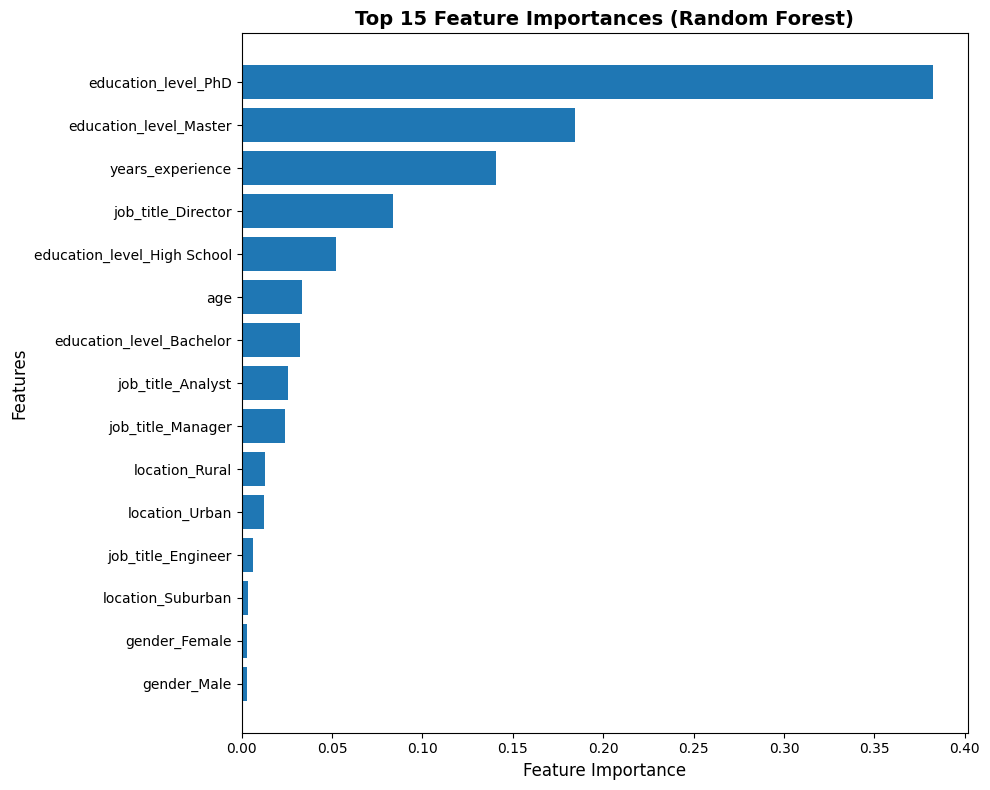

In [11]:
def plot_feature_importance(models, X_train, categorical_features, numerical_features):
    """Plot feature importance for ensemble models"""
    print_section("9. FEATURE IMPORTANCE ANALYSIS")
    
    # Get feature names after preprocessing
    cat_encoder = models['Random Forest'].named_steps['preprocessor'].named_transformers_['cat']
    
    # Get encoded categorical feature names
    cat_feature_names = []
    if hasattr(cat_encoder, 'get_feature_names_out'):
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
    else:
        cat_feature_names = categorical_features
    
    all_feature_names = numerical_features + cat_feature_names
    
    # Random Forest Feature Importance
    rf_model = models['Random Forest'].named_steps['regressor']
    rf_importance = rf_model.feature_importances_
    
    # Create DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': rf_importance
    }).sort_values('Importance', ascending=False)
    
    print("\n📊 Top 15 Most Important Features (Random Forest):")
    print("=" * 60)
    print(f"{'Feature':<40} {'Importance':<20}")
    print("=" * 60)
    for idx, row in importance_df.head(15).iterrows():
        print(f"{row['Feature']:<40} {row['Importance']:<20.4f}")
    print("=" * 60)
    
    # Create visualization
    print("\n📈 Generating feature importance plot...")
    plt.figure(figsize=(10, 8))
    
    top_n = min(20, len(importance_df))
    top_features = importance_df.head(top_n)
    
    plt.barh(range(top_n), top_features['Importance'].values)
    plt.yticks(range(top_n), top_features['Feature'].values)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top {top_n} Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # Save plot
    plot_path = 'feature_importance.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Feature importance plot saved to: {plot_path}")
    
    plt.show()
    plt.close()

# Plot feature importance
plot_feature_importance(all_models, X_train, categorical_features, numerical_features)

## Project Summary


**Generated Files:**
- `best_model.pkl` - Best performing model
- `preprocessor.pkl` - Data preprocessor
- `feature_importance.png` - Feature importance visualization

**Key Achievements:**
1. ✓ Data loaded and inspected successfully
2. ✓ Comprehensive EDA performed
3. ✓ Data preprocessed with proper encoding and scaling
4. ✓ Multiple models trained and evaluated
5. ✓ Best model identified and saved
6. ✓ Feature importance analyzed

### Next Steps
You can now use the saved model for predictions on new data using the `my_prediction.py` script or by loading the model directly:
```python
import joblib
model = joblib.load('best_model.pkl')
preprocessor = joblib.load('preprocessor.pkl')
```